In [1]:
import platform
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from bert_sim import word_sim
from matplotlib import rc
from gensim.models import Word2Vec

warnings.filterwarnings(action='ignore')


Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'
        self.df['효능_Morps'] = self.df['효능'].map(lambda x: self.getMorps(x))
        self.df['효능_NV'] = self.df['효능_Morps'].map(lambda x: self.getNV(x))
        self.df['효능_N'] = self.df['효능_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['효능_count_topn_NV']  = self.df['효능_NV'].map(lambda x: self.counter(x,n)) 
        self.df['효능_count_topn_N']  = self.df['효능_N'].map(lambda x: self.counter(x,n)) 

    def result(self,idx, top , dis):
        energy = ['정열', '활기', '기력', '생기', '활발']
        recovery = ['낫', '치료', '휴식' ,'극복' , '재활']
        cycle = ['운반', '유지', '조절' , '공급' ,'생명']
        pury = ['진정' , '맑' , '없애' , '깨끗하', '해소']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        effs_dims =  [energy, recovery, cycle , pury]
        sNV = self.df['효능'][idx].split(" ")[1:]

        result = []
        for dim in effs_dims:
            ab = []
            for sim_word in dim:
                sub = []
                for word in sNV:
                    try:
                        sub.append(word_sim(sim_word , word))
                    except:
                        sub.append(0)
                ab.append(sub)
                aab = np.array(ab).flatten().tolist()
            aab = np.array(sorted(aab,reverse=True))[:top].mean()
            result.append(aab)
        
        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]
            std = np.std(result)
            
            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 유사어')
            plt.xticks(np.arange(len(effs_dims_name)), effs_dims_name)
            plt.yticks(np.arange(0,1.1,0.1))
            plt.show()
#            print(f'{word}s std is {std}' )
        print(result)
        return result
        
    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_idx,figsize):
        energy = ['정열', '활기', '기력', '생기', '활발','--']
        recovery = ['낫', '치료', '휴식' ,'극복' , '재활', '--']
        cycle = ['운반', '유지', '조절' , '공급' ,'생명', '--']
        pury = ['진정' , '맑' , '없애' , '깨끗하', '해소', '--']        
        effs_dims_name = ['에너지', '회복', '순환', '정화']
        all_dims = energy + recovery + cycle + pury
        
        plt.rc('font', family=self.font)
        sents = self.df['효능'][emotion_idx]
        
        result = []
        spl_sents = sents.split(" ")[1:]
        for word in spl_sents:
            sub = []
            for dim_word in all_dims:
                try:
                    sub.append(self.wiki_model.wv.similarity(dim_word , word))
                except:
                    sub.append(0)
            result.append(sub)

        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        em_name = self.df['감정'][emotion_idx]
        plt.title(f'{em_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(all_dims)),all_dims)
        plt.yticks(np.arange(len(spl_sents)),spl_sents)
        plt.show()
              


In [3]:
# 감정 데이터 확인
em_data = pd.read_csv("../data/emotion_data_hand_craft.csv")
em_data

,감정,효능
0,행복,향유 낙관적 느낌 생각 즐기
1,우울,행동 도움 생활 치료 명상
2,슬픔,사랑 도움 가족 시간 활동
3,열정,상기 집중 노력 몰입 휴식
4,분노,정지 회피 긍정 마음 호흡
5,두려움,직면 변화 대화 집중 용기


### BERT 모델을 사용한 상위 25개의 평균을 확인
실제로 평균효과가 나타나면 어떻게 되는 것인지 확인

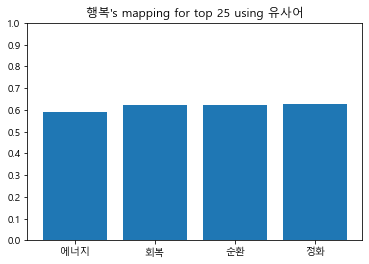

[0.5883623445034027, 0.6234042525291443, 0.6207591664791107, 0.6272668015956878]


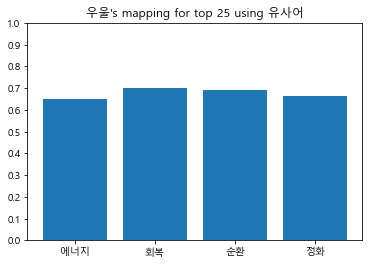

[0.6513512134552002, 0.7019831132888794, 0.6916539216041565, 0.6653492259979248]


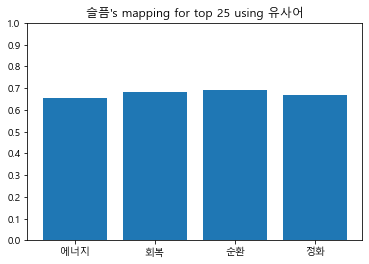

[0.6542152833938598, 0.6840649056434631, 0.6908186841011047, 0.6686051154136657]


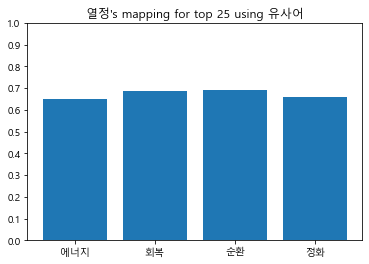

[0.6490820837020874, 0.6855120491981507, 0.6921935725212097, 0.6570543718338012]


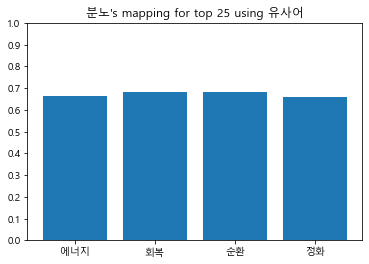

[0.6626829957962036, 0.6805696272850037, 0.6839021039009094, 0.6595045757293702]


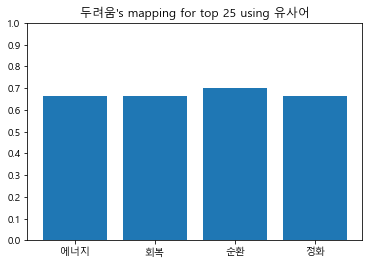

[0.6636316388845444, 0.6638837069272995, 0.7021862894296647, 0.6613990038633346]


In [4]:
hXYZ = check_data(em_data)
for i in em_data.index:
    #hXYZ.get_heatmap(i, (20,4))
    hXYZ.result(i,25,True)